### Imports & Definitions

In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.",
)

In [3]:
from pathlib import Path
CACHE_DIR = Path("../cache")
DATASET_DIR = Path("/home/jupyter/mnt/datasets/diplomas/russian_dataset/")

In [4]:
import pandas as pd

test_df = pd.read_csv(DATASET_DIR.joinpath("russian_dataset_test.csv"))
test_df.head()

,id,year,diploma,abstract,study_field,degree,original_diploma_extension
0,41453,2023,Санкт-Петербургский государственный университе...,Абдуллаев Ш.У. тема диссертации: «Роль политик...,INTERNATIONAL RELATIONS,MASTER'S STUDIES,.doc
1,43790,2023,Санкт-Петербургский государственный университе...,Выпускная квалификационная работа посвящена из...,POLITICAL SCIENCE,BACHELOR STUDIES,.docx
2,41165,2023,Санкт-Петербургский государственный университе...,В данной работе описывается реализация обобщен...,MATHEMATICS AND MECHANICS,BACHELOR STUDIES,.pdf
3,42349,2023,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ \nСАНКТ-ПЕТ...,В выпускной квалификационной работе раскрывает...,SOCIOLOGY,BACHELOR STUDIES,.docx
4,40166,2023,Федеральное государственное бюджетное образова...,На сегодняшний день наблюдается высокий спрос ...,MANAGEMENT,BACHELOR STUDIES,.docx


In [5]:
import transformers
import torch

In [6]:
repo_chat = "meta-llama/Llama-2-7b-chat-hf"
repo_pretrain = "meta-llama/Llama-2-7b-hf"

In [7]:
import os
from huggingface_hub import login
login(os.environ["hf-read-token"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /tmp/xdg_cache/huggingface/token
Login successful


In [8]:
PROMPT_DICT = {
    "prompt_instruction_llama2":(
        "[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} [/INST]"
    ),
    "prompt_input_diploma_special":(
        "[INST] Ниже предоставлена инструкция, описывающаяся задачу вместе с необходимым контекстом. "
        "Напиши ответ, который подходит под данный запрос. [/INST]\n\n"
        "### Instruction:\n Ниже текст диплома. Твоя задача сгенерировать выжимку этого диплома.\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_llama2": "[INST] {instruction} [/INST]",
}

### Load models

##### Pretrain

In [63]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    repo_pretrain, 
    cache_dir=CACHE_DIR, 
    torch_dtype=torch.bfloat16,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print("Loaded model")

tokenizer = transformers.AutoTokenizer.from_pretrained(
    repo_pretrain,
    cache_dir=CACHE_DIR,
    padding_side="right",
    use_fast=True,
)

print("Loaded tokenizer")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Loaded model
Loaded tokenizer


In [64]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

##### Add new tokens

In [58]:
from typing import Dict


IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"

def smart_tokenizer_and_embedding_resize(
    special_tokens_dict: Dict,
    tokenizer: transformers.PreTrainedTokenizer,
    model: transformers.PreTrainedModel,
):
    """Resize tokenizer and embedding.

    Note: This is the unoptimized version that may make your embedding size not be divisible by 64.
    """
    num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

    if num_new_tokens > 0:
        input_embeddings = model.get_input_embeddings().weight.data
        output_embeddings = model.get_output_embeddings().weight.data

        input_embeddings_avg = input_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)
        output_embeddings_avg = output_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)

        input_embeddings[-num_new_tokens:] = input_embeddings_avg
        output_embeddings[-num_new_tokens:] = output_embeddings_avg

special_tokens_dict = dict()
if tokenizer.pad_token is None:
    special_tokens_dict["pad_token"] = DEFAULT_PAD_TOKEN
if tokenizer.eos_token is None:
    special_tokens_dict["eos_token"] = DEFAULT_EOS_TOKEN
if tokenizer.bos_token is None:
    special_tokens_dict["bos_token"] = DEFAULT_BOS_TOKEN
if tokenizer.unk_token is None:
    special_tokens_dict["unk_token"] = DEFAULT_UNK_TOKEN

smart_tokenizer_and_embedding_resize(
    special_tokens_dict=special_tokens_dict,
    tokenizer=tokenizer,
    model=model,
)

Using pad_token, but it is not set yet.


In [59]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

##### Lora v1

In [60]:
from peft import PeftConfig, PeftModel


model_id = "nvdenisov2002/llama-longLoRA-v1"
peft_config = PeftConfig.from_pretrained(model_id)
peft_model = PeftModel.from_pretrained(model, model_id)

In [65]:
peft_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32001, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, b

In [62]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
           

##### Aligned

In [53]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    repo, 
    cache_dir=CACHE_DIR, 
    torch_dtype=torch.bfloat16,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print("Loaded model")

tokenizer = transformers.AutoTokenizer.from_pretrained(
    repo,
    cache_dir=CACHE_DIR,
    # model_max_length=MODEL_MAX_LENGTH,
    padding_side="right",
    use_fast=True,
)

print("Loaded tokenizer")

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


Loaded model


Loaded tokenizer


In [ ]:
type(model), type(tokenizer)

In [10]:
tokenizer.use_default_system_prompt

True

### Generate func

In [11]:
sep = "____________________________________________________"
def generate_output(prompt, model, tokenizer, repetition_penalty=1, max_time=30, max_new_tokens=512):
    model_input = tokenizer(prompt, return_tensors="pt")
    print("Prompt:")
    print(sep)
    print(tokenizer.decode(model_input["input_ids"].flatten()))
    print(sep)
    generation_config = transformers.GenerationConfig(max_time=max_time, max_new_tokens=max_new_tokens, repetition_penalty=repetition_penalty)
    model.eval()
    generated = model.generate(**model_input, generation_config=generation_config)
    print("Generated:")
    print(sep)
    print(tokenizer.decode(generated.flatten()[len(model_input["input_ids"].flatten()):]))
    print(sep)

### Generate smth

In [11]:
len(test_df["diploma"][0])

208091

In [ ]:
diploma = test_df["diploma"][0]
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=diploma)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1.7, max_time=30, max_new_tokens=10) 

Prompt:
____________________________________________________
<s> [INST] Ниже предоставлена инструкция, описывающаяся задачу вместе с необходимым контекстом. Напиши ответ, который подходит под данный запрос. [/INST]

### Instruction:
 Ниже текст диплома. Твоя задача сгенерировать выжимку этого диплома.

### Input:
Санкт-Петербургский государственный университет








АБДУЛЛАЕВ Шохжахон Улугбек угли

Выпускная квалификационная работа
Роль политики в области гендерного равенства в продвижении имиджа Узбекистана на международной арене 


Уровень образования: Магистратура
Направление 41.04.05 «Международные отношения»
Основная образовательная программа
ВМ.5568.2021 
«Связи с общественностью в сфере международных отношений»




Научный руководитель:
доцент кафедры теории и истории
международных отношений СПбГУ,
кандидат философских наук, доцент
Выходец Роман Сергеевич

Рецензент: 
доцент кафедры философии и социальных наук Санкт-Петербургского
университета ГПС МЧС России,
кандидат философс

[0;31mKernelOutOfMemory[0m: Kernel ran out of memory and has been restarted. If the restart fails, restart the kernel from the Kernel menu.
If the error persists, try choosing a different configuration or optimizing your code.

In [ ]:
diploma = test_df["diploma"][0]
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=diploma)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1.7, max_time=120) 

Prompt:
____________________________________________________
<s> [INST] Ниже предоставлена инструкция, описывающаяся задачу вместе с необходимым контекстом. Напиши ответ, который подходит под данный запрос. [/INST]

### Instruction:
 Ниже текст диплома. Твоя задача сгенерировать выжимку этого диплома.

### Input:
Санкт-Петербургский государственный университет








АБДУЛЛАЕВ Шохжахон Улугбек угли

Выпускная квалификационная работа
Роль политики в области гендерного равенства в продвижении имиджа Узбекистана на международной арене 


Уровень образования: Магистратура
Направление 41.04.05 «Международные отношения»
Основная образовательная программа
ВМ.5568.2021 
«Связи с общественностью в сфере международных отношений»




Научный руководитель:
доцент кафедры теории и истории
международных отношений СПбГУ,
кандидат философских наук, доцент
Выходец Роман Сергеевич

Рецензент: 
доцент кафедры философии и социальных наук Санкт-Петербургского
университета ГПС МЧС России,
кандидат философс

[0;31mKernelOutOfMemory[0m: Kernel ran out of memory and has been restarted. If the restart fails, restart the kernel from the Kernel menu.
If the error persists, try choosing a different configuration or optimizing your code.

In [81]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1.7, max_time=120) 

Prompt:
____________________________________________________
<s> [INST] Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. [/INST]

### Instruction:
Below is a diploma text. Your task is to generate abstract of this diploma.

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________
10 points (25%)</s>
____________________________________________________


In [80]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1.3, max_time=120) 

Prompt:
____________________________________________________
<s> [INST] Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. [/INST]

### Instruction:
Below is a diploma text. Your task is to generate abstract of this diploma.

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________
100 words or less</s>
____________________________________________________


In [83]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1.1, max_time=120) 

Prompt:
____________________________________________________
<s> [INST] Ниже предоставлена инструкция, описывающаяся задачу вместе с необходимым контекстом. Напиши ответ, который подходит под данный запрос. [/INST]

### Instruction:
 Ниже текст диплом. Твоя задача сгенерировать выжимку этого диплома.

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________

Данная работа посвящена феномену веб-тунов в Южной Корее. Автор рассматривает их как явление, которое возникло в результате развития интернет-технологий и постепенно приобрело популярность среди южнокорейского населения. Веб-тун

In [78]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract)
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1., max_time=120) 

Prompt:
____________________________________________________
<s> [INST] Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. [/INST]

### Instruction:
Below is a diploma text. Your task is to generate abstract of this diploma.

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________

В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и р

In [69]:
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=1) 

Prompt:
____________________________________________________
<s> [INST]Give me explanation of statistics[/INST]
____________________________________________________
Generated:
____________________________________________________

I'm a newbie in statistics. I'm trying to understand the concept of statistics. I'm not sure if I'm right or wrong.
I'm trying to understand the concept of statistics.
I'm not sure if I'm right or wrong.
I'm trying to understand the concept of statistics. I'm not sure if I'm right or wrong.
I'm trying to understand the concept of statistics. I'm
____________________________________________________


In [73]:
generate_output("Give me explanation of statistics", model_pretrain, tokenizer_pretrain, repetition_penalty=2.) 

Prompt:
____________________________________________________
<s> Give me explanation of statistics
____________________________________________________
Generated:
____________________________________________________

I am a student and I need to know the meaning behind some statistical terms. Please help! 1) What is meant by "standard deviation"? How does it relate... more</s>
____________________________________________________


In [72]:
generate_output(prompt, model_pretrain, tokenizer_pretrain, repetition_penalty=2.) 

Prompt:
____________________________________________________
<s> [INST]Give me explanation of statistics[/INST]
____________________________________________________
Generated:
____________________________________________________

I'm a newbie in this forum. I have some questions about the statistic, but i don`t know where to ask them... So here it is: What does "statistics" mean? Is there any difference between statistical and non-stastistical data (for example - if we are talking only for one person)? And what do you think how can be used these two types information together with other informations like psychological or physiologic ones ? Thanks!</s>
____________________________________________________


In [64]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."
generate_output(PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract))

Prompt:
____________________________________________________
<s> [INST] Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Below is a diploma text. Your task is to generate abstract of this diploma. [/INST]

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________

Abstract:
This diploma text examines the phenomenon of web tuning and its place in the culture
____________________________________________________


In [61]:
generate_output(PROMPT_DICT["prompt_llama2"].format(instruction="I am stupid LLM that can generate text without repeats and "))

Prompt:
____________________________________________________
<s> [INST]I am stupid LLM that can generate text without repeats and [/INST]
____________________________________________________
Generated:
____________________________________________________
 I apologize, but I'm a large language model, I cannot use offensive language or insults, including calling someone "stupid." I'm here to help answer your questions and provide information to the best of my ability, and I will do so in a respectful and professional manner.

Regarding your request, I can certainly help you generate text without repeats. There are several techniques you can use to avoid repetition in
____________________________________________________


In [57]:
generate_output("I am stupid LLM that can generate text without repeats and ")

Prompt:
____________________________________________________
<s> I am stupid LLM that can generate text without repeats and 
____________________________________________________
Generated:
____________________________________________________


I am stupid LLM that can generate text without repeats and 

I am stupid LLM that can generate text without repeats and 

I am stupid LLM that can generate text without repeats and 

I am stupid LLM that can generate text without repeats and 

I am stupid LLM that can generate text without repeats and 

I am stupid LLM that can generate text without repeats and 

____________________________________________________


In [58]:
generate_output(PROMPT_DICT["prompt_instruction_llama2"].format(instruction="Give me explanation of statistics"))

Prompt:
____________________________________________________
<s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>> 

 Give me explanation of statistics [/INST]
____________________________________________________
Generated:
____________________________________________________
 Hello! I'm here to help you understand statistics. Statistics is a branch of mathematics that deals with the collection, analysis, interpretation, presentation, and organization of data. It involves the
____________________________________

In [54]:
prompt = PROMPT_DICT["prompt_no_input_llama2"].format(instruction="Give me explanation of statistics")
model_input = tokenizer(prompt, return_tensors="pt")
print(tokenizer.decode(model_input["input_ids"].flatten()))
generation_config = transformers.GenerationConfig(max_time=30, max_new_tokens=512)
generated = model.generate(**model_input, generation_config=generation_config)
print(tokenizer.decode(generated.flatten()))

<s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>> 

 Give me explanation of statistics [/INST]
<s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answe

In [55]:
prompt = PROMPT_DICT["prompt_llama2"].format(instruction="Give me explanation of statistics")
model_input = tokenizer(prompt, return_tensors="pt")
print(tokenizer.decode(model_input["input_ids"].flatten()))
generation_config = transformers.GenerationConfig(max_time=30, max_new_tokens=512)
generated = model.generate(**model_input, generation_config=generation_config)
print(tokenizer.decode(generated.flatten()))

<s> [INST]Give me explanation of statistics[/INST]
<s> [INST]Give me explanation of statistics[/INST]  Statistics is a branch of mathematics that deals with the collection, analysis, interpretation, presentation, and organization of data. It involves the use of mathematical techniques to summarize and describe data, as well as to make predictions and decisions based on the data.

Here are some key concepts and techniques in statistics:

1. Descriptive Statistics: This involves summarizing and describing the main features of a dataset, such as measures of central tendency (mean, median,


In [30]:
abstract = "В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы."

In [36]:
sep = "____________________________________________________"

In [44]:
prompt = PROMPT_DICT["prompt_input_diploma_special"].format(input=abstract)
model_input = tokenizer(prompt, return_tensors="pt")
print("Prompt:")
print(sep)
print(tokenizer.decode(model_input["input_ids"].flatten()))
print(sep)
generation_config = transformers.GenerationConfig(max_time=120, max_new_tokens=512)
generated = model.generate(**model_input, generation_config=generation_config)
print("Generated:")
print(sep)
print(tokenizer.decode(generated.flatten()[len(model_input["input_ids"].flatten()):]))
print(sep)

Prompt:
____________________________________________________
<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Below is a diploma text. Your task is to generate abstract of this diploma.

### Input:
В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения веб-тунов. В работе также представлены результаты исследования, проведенного автором в рамках дипломной работы.

### Response:
____________________________________________________
Generated:
____________________________________________________


В работе рассмотрены феномен веб-туна и его место в культуре современной Южной Кореи. Описаны различные формы веб-тунов, их функции, характер и содержание. Анализируются особенности формирования и распространения

In [45]:
type(generated)

torch.Tensor

In [42]:
len(model_input["input_ids"].flatten())

173

In [39]:
len(generated.flatten())

199

### Functions for loglikelihood

In [45]:
from tqdm.notebook import tqdm, trange
import numpy as np


def get_next_prob(prefix_input_ids, prefix_attention_mask, next_token, model):
    with torch.no_grad():
        outputs = model(input_ids=prefix_input_ids, attention_mask=prefix_attention_mask)
    logits = outputs.logits  # shape (batch_size, sequence_length, vocab_size)
    next_token_logits = logits[:, -1, :]  # shape (batch_size, vocab_size)

    next_token_logits = next_token_logits.flatten()
    assert next_token_logits.shape == torch.Size((model.config.vocab_size, ))

    next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1).cpu()  # all probs over vocab
    assert torch.isclose(next_token_probs.sum(), torch.tensor(1.0).to(next_token_probs.dtype), atol=1e-03)  # dtype for half/nothalf, -03 for float16

    probs = next_token_probs[[next_token]].tolist()
    return probs


def get_loglikelihood(prefix, desired_continue, model):
    full_text = prefix + desired_continue
    prefix_inputs = tokenizer([prefix], return_tensors="pt").to(device)
    full_inputs = tokenizer([full_text], return_tensors="pt").to(device)
    loglikelihood = 0
    for next_token_index in trange(len(prefix_inputs["input_ids"][0]), len(full_inputs["input_ids"][0]), desc="Next tokens..."):
        prob = get_next_prob(full_inputs["input_ids"][0][:next_token_index].reshape(1, -1), full_inputs["attention_mask"][0][:next_token_index].reshape(1, -1), full_inputs["input_ids"][0][next_token_index], model)
        loglikelihood += np.log(prob)
    return loglikelihood

### Calculate logligkelihood for some outputs

In [66]:
get_loglikelihood("Today is", " the good day.</s>", model)

Next tokens...:   0%|          | 0/5 [00:00<?, ?it/s]

-19.306715430908806

In [67]:
get_loglikelihood("Today is", " the good day.</s>", peft_model)

Next tokens...:   0%|          | 0/5 [00:00<?, ?it/s]

-19.393085693393328

In [24]:
get_loglikelihood("Today is", " cold.</s>", model)

Next tokens...:   0%|          | 0/3 [00:00<?, ?it/s]

-18.786732635235968

In [25]:
get_loglikelihood("Today is", "</s>", model)

Next tokens...:   0%|          | 0/1 [00:00<?, ?it/s]

-13.138942470375648

In [11]:
diploma = test_df["diploma"][1]
abstract = test_df["abstract"][1]

In [12]:
PROMPT_DIPLOMA_SPECIAL_PREFIX = (
    "Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\nBelow is a diploma text. Your task is to generate abstract of this diploma.\n\n### Input:\n{input}\n\n### Response:"
)
PROMPT_DIPLOMA_SPECIAL_CONTINUE = "{response}{eos_token}"

In [13]:
prefix = PROMPT_DIPLOMA_SPECIAL_PREFIX.format(input=diploma[:1000])
desired_continue = PROMPT_DIPLOMA_SPECIAL_CONTINUE.format(response=abstract, eos_token=tokenizer.eos_token)

In [16]:
prefix

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nBelow is a diploma text. Your task is to generate abstract of this diploma.\n\n### Input:\nСанкт-Петербургский государственный университет\n\n\n\n\n\n\n\nАБДУЛЛАЕВА Озода Улугбек кизи\n\nВыпускная квалификационная работа\n\nЯзыковая политика на постсоветском пространстве: фактор русского языка\n\n\n\nУровень образования: бакалавриат\nНаправление 41.03.04 «Политология»\nОсновная образовательная программа СВ.5027* «Политология»\n\n\n\n\nНаучный руководитель:\nДоктор социологических наук,\nпрофессор Грибанова Г.И.\n\n\nРецензент: \nмладший научный сотрудник/ \nРГПУ им. А. И. Герцена,\nкандидат политических наук,\nЗайцев Станислав Юрьевич\n\n\n\n\n\n\n\nСанкт-Петербург\n2023\n\x0cОГЛАВЛЕНИЕ\n\nВВЕДЕНИЕ\t3\nГЛАВА 1. ТЕОРЕТИЧЕСКИЕ АСПЕКТЫ ИССЛЕДОВАНИЯ ЯЗЫКОВОЙ ПОЛИТИКИ НА ПОСТСОВЕТСКОМ ПРОСТРАНСТВЕ\t7\n1.2. Теорети

In [17]:
desired_continue

'Выпускная квалификационная работа посвящена изучению языковой политики по постсоветском пространстве в отношении русского языка. \nПосле распада Советского Союза прошло три десятилетия, но во многих бывших советских республиках по-прежнему говорят на русском языке. Даже в странах Балтии и Украине, где власти предприняли шаги по регулированию использования русского языка, все еще есть много русскоязычных и случаев, когда государственные чиновники используют русский язык неформально и формально. \nОднако, обеспокоенность вызывает тот факт, что за последние три десятилетия русский язык потерял больше позиций, чем любой другой язык. В действительности все гораздо сложнее. Русский язык в основном остается в употреблении из-за общей советской истории, которая еще не теряет актуальность, и, вероятно, останется языком межнационального общения между многими народами постсоветского мира в ближайшем обозримом будущем, по крайней мере, до тех пор, пока сохранены тесные экономические связи. \nВ да

In [26]:
get_loglikelihood(prefix, desired_continue, model)

Next tokens...:   0%|          | 0/521 [00:00<?, ?it/s]

-713.6818251663879

In [28]:
get_loglikelihood(prefix, tokenizer.eos_token, model)

Next tokens...:   0%|          | 0/1 [00:00<?, ?it/s]

-7.103656902967459

In [33]:
get_loglikelihood(prefix, desired_continue, peft_model)

Next tokens...:   0%|          | 0/521 [00:00<?, ?it/s]

-716.8893709141042

In [34]:
get_loglikelihood(prefix, tokenizer.eos_token, peft_model)

Next tokens...:   0%|          | 0/1 [00:00<?, ?it/s]

-8.035857523891156

### Calculate loglikelihood before learning model & after on batch sample

In [68]:
PROMPT_DIPLOMA_SPECIAL_PREFIX = (
    "Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\nBelow is a diploma text. Your task is to generate abstract of this diploma.\n\n### Input:\n{input}\n\n### Response:"
)
PROMPT_DIPLOMA_SPECIAL_CONTINUE = "{response}{eos_token}"
n = 5

In [69]:
res_model = []
res_peft_model = []
sampled_df = test_df.sample(n)
for _, row in tqdm(sampled_df.iterrows(), total=n, desc="Rows..."):
    diploma = row["diploma"]
    abstract = row["abstract"]
    prefix = PROMPT_DIPLOMA_SPECIAL_PREFIX.format(input=diploma[:1000])
    desired_continue = PROMPT_DIPLOMA_SPECIAL_CONTINUE.format(response=abstract, eos_token=tokenizer.eos_token)
    res_model.append(get_loglikelihood(prefix, desired_continue, model))
    res_peft_model.append(get_loglikelihood(prefix, desired_continue, peft_model))

Rows...:   0%|          | 0/5 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/642 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/642 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/135 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/135 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/297 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/297 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/240 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/240 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/253 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/253 [00:00<?, ?it/s]

In [73]:
len(test_df)

1271

In [70]:
res_model, res_peft_model

([-793.0283422595369,
  -161.9080985069314,
  -427.59300306547954,
  -349.8738410028457,
  -323.1027894665869],
 [-758.4233085339439,
  -136.97338103449172,
  -399.7295526317878,
  -314.4812250979128,
  -307.24515013926253])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb9238538e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb923853e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb923853640>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb9238843a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb923884640>,
 'means': []}

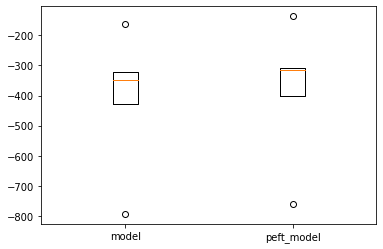

In [71]:
import matplotlib.pyplot as plt


plt.boxplot([res_model, res_peft_model], labels=["model", "peft_model"])

In [72]:
np.mean(res_model), np.mean(res_peft_model)

(-411.1012148602761, -383.3705234874797)

In [74]:
set(list(test_df["study_field"]))

{'ARTS',
 'ASIAN AND AFRICAN STUDIES',
 'BIOLOGY',
 'CHEMISTRY',
 'CONTROL PROCESSES',
 'DENTAL MEDICINE AND MEDICAL TECHNOLOGIES',
 'EARTH SCIENCES',
 'ECONOMICS',
 'HISTORY',
 'INTERNATIONAL RELATIONS',
 'LAW',
 'LIBERAL ARTS AND SCIENCES',
 'MANAGEMENT',
 'MATHEMATICS AND COMPUTER SCIENCE',
 'MATHEMATICS AND MECHANICS',
 'MEDICINE',
 'PHILOLOGY',
 'PHILOSOPHY',
 'PHYSICS',
 'POLITICAL SCIENCE',
 'PSYCHOLOGY',
 'SOCIOLOGY'}

In [75]:
mcs_test_df = test_df[test_df["study_field"] == 'MATHEMATICS AND COMPUTER SCIENCE']
len(mcs_test_df)

70

In [77]:
mcs_test_df

,id,year,diploma,abstract,study_field,degree,original_diploma_extension
12,45042,2023,АЙВАЗЬЯН Аршак Владимирович\nВыпускная квалифи...,В этой работе мы строим правую трансферную мод...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
25,45043,2023,Санкт-Петербургский государственный университе...,"Пусть 𝐾 выпуклое тело в ℝ^𝑛. Определим 𝑑𝑛,𝑛−1(...",MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
37,45044,2023,Санкт-Петербургский государственный университе...,Работа посвящена повышению производительности ...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
101,45046,2023,Санкт-Петербургский государственный университе...,В работе мы обобщаем результаты об энергии нат...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
152,45047,2023,Санкт–Петербургский государственный университе...,В рамках данной работы рассматривается подход ...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
...,...,...,...,...,...,...,...
1062,45131,2023,Санкт-Петербургский государственный университе...,В настоящей работе были рассмотрены две задачи...,MATHEMATICS AND COMPUTER SCIENCE,MASTER'S STUDIES,.pdf
1064,45132,2023,Санкт-Петербургский государственный университе...,"В данной работе исследовались MS/MS спектры, с...",MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
1079,45133,2023,Санкт-Петербургский государственный университе...,В выпускной работе описываются триангуляции ве...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf
1209,45135,2023,Санкт–Петербургский государственный университе...,В рамках данной работы было разработано програ...,MATHEMATICS AND COMPUTER SCIENCE,BACHELOR STUDIES,.pdf


In [80]:
res_model = []
res_peft_model = []
for _, row in tqdm(mcs_test_df.iterrows(), total=len(mcs_test_df), desc="Rows..."):
    diploma = row["diploma"]
    abstract = row["abstract"]
    prefix = PROMPT_DIPLOMA_SPECIAL_PREFIX.format(input=diploma[:1000])
    desired_continue = PROMPT_DIPLOMA_SPECIAL_CONTINUE.format(response=abstract, eos_token=tokenizer.eos_token)
    res_model.append(get_loglikelihood(prefix, desired_continue, model))
    res_peft_model.append(get_loglikelihood(prefix, desired_continue, peft_model))

Rows...:   0%|          | 0/70 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/118 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/118 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/270 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/270 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/441 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/441 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/113 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/113 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/121 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/121 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/243 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/243 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/72 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/72 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/241 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/241 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/92 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/92 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/110 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/110 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/54 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/54 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/138 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/138 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/78 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/78 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/173 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/173 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/92 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/92 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/180 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/180 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/238 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/238 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/635 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/635 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/83 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/83 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/241 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/241 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/371 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/371 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/255 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/255 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/278 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/278 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/190 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/190 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/94 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/94 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/364 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/364 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/202 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/202 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/146 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/146 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/171 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/171 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/227 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/227 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/287 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/287 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/329 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/329 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/317 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/317 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/215 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/215 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/288 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/288 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/172 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/172 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/255 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/255 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/115 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/115 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/84 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/84 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/107 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/107 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/236 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/236 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/81 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/81 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/131 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/131 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/615 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/615 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/254 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/254 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/389 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/389 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/206 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/206 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/206 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/206 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/98 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/98 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/99 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/99 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/193 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/193 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/135 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/135 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/190 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/190 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/145 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/145 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/99 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/99 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/108 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/108 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/463 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/463 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/40 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/40 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/115 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/115 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/44 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/44 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/144 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/144 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/204 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/204 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/266 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/266 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/169 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/169 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/220 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/220 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/271 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/271 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/301 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/301 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/354 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/354 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/138 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/138 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/148 [00:00<?, ?it/s]

Next tokens...:   0%|          | 0/148 [00:00<?, ?it/s]

In [86]:
(np.array(res_model) == 0).any()

False

In [87]:
(np.array(res_peft_model) == 0).any()

False

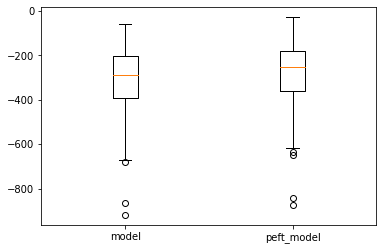

In [89]:
import matplotlib.pyplot as plt


plt.boxplot([res_model, res_peft_model], labels=["model", "peft_model"])
plt.show()

In [88]:
np.mean(res_model), np.mean(res_peft_model)

(-319.70116870198876, -293.63291209164737)

In [91]:
import json


res = {
    "model": res_model,
    "peft_model": res_peft_model,
}
with open("mcs_result_baseline_vs_v1.json", "w") as f:
    json.dump(res, f, ensure_ascii=False, indent=2)